In [2]:
# Libraries for Scientific Computing
import numpy as np
import pyquaternion as pyQ

# Libraries for graphics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import juggle_axes

import scipy.integrate

### Mechanics

In [27]:
def mechanics(r_0, r, masses, q_0, p_0, t, tmax, n, body_lines, name = 'CubeQ'):    
    
    ## Identity Rotation
    q_0 = [q for q in q_0]
    positions = np.empty([len(masses), 3, n])
    
    ### Physics
    
    
    ##### Inertial Tensor
    ### Input:  r -> positions;
    ###         masses -> masses from the body;
    ### Output: I -> Matrix representing the Inertial Tensor
    ##### Gil Miranda - last revision 15/09/2019

    def getInertialTensor(r, masses):
        I = np.zeros((3,3))
        for i in range(len(masses)):
            I[0][0] += masses[i]*(r[i][1]**2 + r[i][2]**2)
            I[1][1] += masses[i]*(r[i][0]**2 + r[i][2]**2)
            I[2][2] += masses[i]*(r[i][0]**2 + r[i][1]**2)

            I[0][1] -= masses[i]*(r[i][0])*(r[i][1])
            I[0][2] -= masses[i]*(r[i][0])*(r[i][2])
            I[1][2] -= masses[i]*(r[i][1])*(r[i][2])
        I[1][0] = I[0][1]
        I[2][0] = I[0][2]
        I[2][1] = I[1][2]

        return I

    ## ----------------------Rever este-----------------------------------------

    ##### Internal Angular Momentum
    ### Input:  Q -> ?;
    ###         v -> ?;
    ###         masses -> masses from the body;
    ### Output: s -> ?
    ##### Gil Miranda - last revision 15/09/2019

    def getInternalAngularMomentum(Q, v, masses):
        s = np.zeros(3)
        for (i,m) in enumerate(masses):
            s = s + m*np.cross(Q[i], v[i])
        return s
    
    ##### Center of Mass
    ### Input:  r -> position vector;
    ###         masses -> masses from the body;
    ### Output: cm -> vector for center of mass of the system
    ##### Gil Miranda - last revision 15/09/2019
    def CM(r, masses):
        cm = np.zeros(3)
        for i in range(len(r)):
            cm[0] += masses[i] * r[i][0]
            cm[1] += masses[i] * r[i][1]
            cm[2] += masses[i] * r[i][2]
        total_m = sum(masses)
        cm *= (1/total_m)
        return cm

    def translation_CM():
        r_cm = CM(r_0, masses)
        for i in range(len(r_0)):
            r_0[i] -= r_cm
            
    def particles(t, r):
        a = np.zeros([len(masses), 3])
        for i in range(len(masses)):
            a[i] = r[i](t)
        return a

    def eqOfMotion(x, t):
        # q -> quaternion for rotation
        # p -> body angular momentum
        q = pyQ.Quaternion(x[:4])
        p = x[4:]
        # Position
        pos = particles(t, r)

        #Velocities
        ep = 1e-7
        v = (particles(t+ep, r) - particles(t-ep, r))/(2*ep)

        # Tensor of Inertia
        I = getInertialTensor(pos, masses)
        Iinv = np.linalg.inv(I)

        # Angular Momentum
        L = getInternalAngularMomentum(pos, v, masses)
        dumb = np.dot(Iinv, (p-L))
        dp_dt = np.cross(p,dumb)

        omega_i = np.dot(Iinv, (p-L))
        omega = pyQ.Quaternion(0, omega_i[0], omega_i[1], omega_i[2])
    #     omega = np.concatenate(([0.], omega))
        dq_dt = 0.5 * q * omega
        return [dq_dt[0],dq_dt[1],dq_dt[2],dq_dt[3]] + [dp_dt[0], dp_dt[1], dp_dt[2]]

    def solve_eq(q_0, p_0, t):
        args = (getInertialTensor,getInternalAngularMomentum)
        q = scipy.integrate.odeint(eqOfMotion,q_0+p_0,t)
        q = np.transpose(q)
        q = q[:4,:]
        return q
    
    def set_positions(q, n, tmax):
        for k, rot in enumerate(np.transpose(q)):
            t = k*tmax/n
            p = particles(t, r)
            for i in range(0, len(masses)):
                q = pyQ.Quaternion(rot)
                positions[i, : ,k] = q.rotate(p[i, :])
    
    translation_CM()
    q = solve_eq(q_0, p_0, t)
    set_positions(q, n, tmax)
    
    ## Graphics
    
    def update_plot(num, positions, body_lines, ani_lines, sc):
        t = tmax*num/num_times
        for line, (sp, ep) in zip(ani_lines, body_lines):
            line._verts3d = positions[[sp,ep], :, num].T.tolist()
        sc._offsets3d = juggle_axes(positions[:,0, num], positions[:,1, num], positions[:,2, num], 'z')
        return sc


    #Create figure object and set animation
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim3d([-1.0, 1.0])
    ax.set_ylim3d([-1.0, 1.0])
    ax.set_zlim3d([-1.0, 1.0])
    #ax.grid()


    # Lines between parts of cat

    ani_lines = [ax.plot([], [], [], 'k-')[0] for _ in body_lines]


    sc = ax.scatter3D(positions[:,0, 0], positions[:,1, 0], positions[:,2, 0], marker='o', c='red', s = 60)
    #for sp, ep in body_lines:
    #    ax.plot(positions[sp:ep, 0, 0], positions[sp:ep, 1, 0], positions[sp:ep, 2, 0])


    ani = FuncAnimation(fig, update_plot,  frames=len(time), interval=2,
            fargs=(positions, body_lines, ani_lines, sc), repeat=True)
    plt.show()
    ani.save('./'+ name + '.gif', writer='pillow', fps=15)

### Initial Values

In [16]:
## Ok

masses = np.array([1,1,1,1,1,1,1,1,.5,.5])
n_mass = len(masses)
r_0 = [None]*n_mass

r_0[0] = [1, 1, 0] # Center of the Body
r_0[1] = [1, -1, 0] # Back of the Body
r_0[2] = [-1, 1, 0] # Back Paw 1
r_0[3] = [-1, -1, 0] # Back Paw 2
r_0[4] = [1, 1, -1] # Tails
r_0[5] = [1,-1,-1]
r_0[6] = [-1,1,-1] # Front Body
r_0[7] = [-1, -1, -1] # Front Paw 1
r_0[8] = [0, -.5, .5] # Front Paw 2
r_0[9] = [0, .5, .5] # Head

r_0 = np.array(r_0)

#### Translation so we have $CM = (0,0,0)$

### Visualizing the Cube

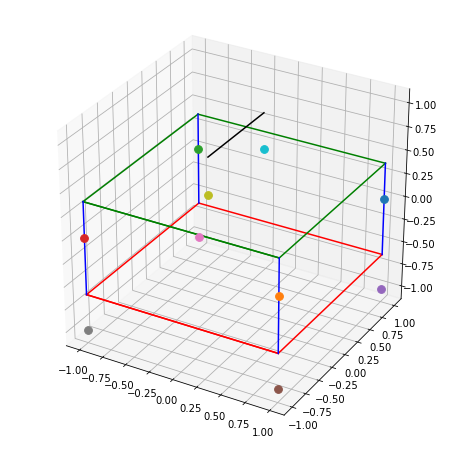

In [17]:

#Only used in animation
body_lines = [
    ## top
    (0, 1),
    (0, 2),
    (1, 3),
    (3, 2),

    ## bottom
    (4, 5),
    (4, 6),
    (5, 7),
    (7, 6),
    
    ## vertical
    (0, 4),
    (1, 5),
    (3, 7),
    (2, 6),
    
    ## propeller
    (8, 9)
]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')
ani_lines = [ax.plot([], [], [], 'k-')[0] for _ in body_lines]

#for line, (sp, ep) in zip(ani_lines, body_lines):
#    line._verts3d = positions[[sp,ep], :, num].T.tolist()

## Base of the cube
ax.plot([-1,1],[-1,-1],[-0.61111111,-0.61111111], color = 'r')
ax.plot([1,1],[-1,1],[-0.61111111,-0.61111111], color = 'r')
ax.plot([-1,1],[-1,-1],[-0.61111111,-0.61111111], color = 'r')
ax.plot([1,-1],[1,1],[-0.61111111,-0.61111111], color = 'r')
ax.plot([-1,-1],[-1,1],[-0.61111111,-0.61111111], color = 'r')

## Top of the cube
ax.plot([-1,1],[-1,-1],[0.38888889,0.38888889], color = 'g')
ax.plot([1,1],[-1,1],[0.38888889,0.38888889], color = 'g')
ax.plot([-1,1],[-1,-1],[0.38888889,0.38888889], color = 'g')
ax.plot([1,-1],[1,1],[0.38888889,0.38888889], color = 'g')
ax.plot([-1,-1],[-1,1],[0.38888889,0.38888889], color = 'g')

## Vertical Lines
ax.plot([-1,-1],[-1,-1],[0.38888889,-0.61111111], color = 'b')
ax.plot([-1,-1],[1,1],[0.38888889,-0.61111111], color = 'b')
ax.plot([1,1],[1,1],[0.38888889,-0.61111111], color = 'b')
ax.plot([1,1],[-1,-1],[0.38888889,-0.61111111], color = 'b')

## helice
ax.plot([0,0],[-.5,.5],[0.88888889,0.88888889], color = 'black')


for i,r in enumerate(r_0):
    ax.scatter3D(r[0], r[1], r[2], label = i, s = 60)
plt.show()

#### Motion

In [18]:
q_0 = pyQ.Quaternion(axis = [1,0,0], radians = 0)
p_0 = [0,0,5]

tmax = 10
num_times = 400
time = np.linspace(0,tmax,num_times)
r = [0 for i in range(0, len(masses))]

## wth is going on here?
for i in range(0,len(masses)):
    r[i] = lambda t, i=i: r_0[i, :]

tmax_r1 = tmax/20
ang_max = np.pi/2
freq = 2*np.pi/tmax
for i in range(len(masses)-2):
    def ri(t, j=i):
        q = pyQ.Quaternion(axis = [0,0,1], radians = freq*t/tmax_r1)
        return q.rotate(r_0[j])
    r[i] = ri
    
for i in (8,9):
    def ri(t, j=i):
        q = pyQ.Quaternion(axis = [0,0,1], radians = -freq*t/tmax_r1)
        return q.rotate(r_0[j])
    r[i] = ri
    


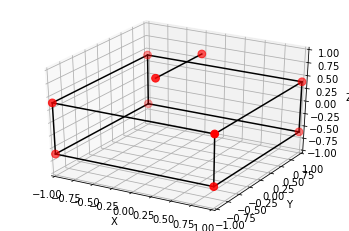

In [28]:
mechanics(r_0, r, masses, q_0, p_0, time, tmax, num_times, body_lines, name = 'encapsulado')